# CME 193 – Lecture 8: Introduction to Deep Learning andNeural Networks with PyTorch

In this notebook we apply PyTorch to build, train, and evaluate a simple neural network on handwritten digit data. We focus on the end-to-end workflow (data, model, optimization, evaluation, and persistence) so students can run everything on CPU-only laptops.

## Annoucements
- Homework 2 has been released last week, and it will be due on **11/28/2025 (Friday)**.
- The second homework is designed to be short and open-ended to reduce the time needed for completing this homework.
- Similar to homework 1, you can apply late days on the second homework.
- There is a non-negotiable deadline for HW2 on 12/14/2025 (Sunday) because I need to submit your grades to the department/university by Mid-December.


## Roadmap for Today

1. Setup & environment checks *(5 minutes)*
2. MNIST dataloaders with a scikit-learn fallback *(10 minutes)*
3. Building a multilayer perceptron classifier *(10 minutes)*
4. Training loop on CPU-only hardware *(15 minutes)*
5. Evaluation, diagnostics, and model persistence *(10 minutes)*
6. Optional CNN extension & student exercises *(time permitting)*


In [70]:
# Optional: uncomment the line below in Colab/local environments without PyTorch installed.
# !pip install torch torchvision
# ! pip install torchinfo

In [71]:
from __future__ import annotations

import random
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import sklearn
import torch
from sklearn.metrics import confusion_matrix
from torch import nn
from torch.utils.data import DataLoader
from torchinfo import summary
from torchvision import datasets, transforms

print(f"Python: {sys.version.split()[0]}")
print(f"PyTorch: {torch.__version__}")
try:
    import torchvision
    print(f"Torchvision: {torchvision.__version__}")
except ImportError:  # pragma: no cover
    print("Torchvision: not available (install for MNIST downloads)")
print(f"scikit-learn: {sklearn.__version__}")


Python: 3.12.11
PyTorch: 2.8.0
Torchvision: 0.23.0
scikit-learn: 1.7.2


## Set random seeds for reproducibility

- Setting a fixed random seed ensures that every run of this notebook produces identical results—same weight initialization, same data shuffling, same train/test splits.
- This reproducibility is critical for debugging, comparing hyperparameters, and sharing results with collaborators and readers of your codebase/paper.
- We seed Python's `random`, NumPy, and PyTorch (including CUDA if available) so that all sources of randomness are controlled.

In [72]:
SEED = 193
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Choose the best available device

PyTorch can run on different hardware accelerators:

- **CUDA** (NVIDIA GPUs) – fastest for large models and datasets
- **MPS** (Apple Silicon) – hardware acceleration using the Metal framework on Apple Silicon
- **CPU** – universally available and perfectly fine for this lecture's small models

The code below automatically detects and selects the best device available on your system.

For the examples in this notebook and homework 2, CPU performance is more than adequate and training completes in seconds.

GPU acceleration becomes essential when scaling to larger networks, bigger datasets, or production workloads.


In [73]:
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device: {device}")

# Create an outputs folder for saved models/artifacts.
OUTPUT_DIR = Path("../outputs")
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)
print(f"Artifacts will be saved to: {OUTPUT_DIR.resolve()}")

Using device: mps
Artifacts will be saved to: /Users/tianyudu/Development/CME193-Autumn-2025/outputs


## 1. MNIST Datasets with Offline Fallback

We will grab the MNIST handwritten digit dataset via `torchvision`. If the download step fails (e.g., no internet), we fall back to scikit-learn's `load_digits()` dataset (8×8 grayscale) so students can still follow along. Both datasets are normalized to `[0, 1]` and exposed through PyTorch `DataLoader`s.


In [121]:
BATCH_SIZE = 5120


class SimpleLoader:
    def __init__(self, images: torch.Tensor, labels: torch.Tensor, batch_size: int, shuffle: bool):
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_samples = images.size(0)

    def __len__(self) -> int:
        return (self.num_samples + self.batch_size - 1) // self.batch_size

    def __iter__(self):
        indices = torch.arange(self.num_samples)
        if self.shuffle:
            indices = torch.randperm(self.num_samples)
        for start in range(0, self.num_samples, self.batch_size):
            end = start + self.batch_size
            batch_idx = indices[start:end]
            yield self.images[batch_idx], self.labels[batch_idx]


def get_dataloaders(batch_size: int = BATCH_SIZE):
    """Return train/test simple loaders for MNIST (no DataLoader)."""

    train_ds = datasets.MNIST(root="./data", train=True, download=True)
    test_ds = datasets.MNIST(root="./data", train=False, download=True)

    # Convert to float in [0, 1] and keep shape (H, W) without channel dim
    train_images = train_ds.data.float() / 255.0
    train_labels = train_ds.targets
    test_images = test_ds.data.float() / 255.0
    test_labels = test_ds.targets

    train_loader = SimpleLoader(train_images, train_labels, batch_size=batch_size, shuffle=True)
    test_loader = SimpleLoader(test_images, test_labels, batch_size=batch_size, shuffle=False)

    input_dim = int(np.prod(train_images[0].shape))
    label_names = list(train_ds.classes)
    dataset_name = "torchvision MNIST (28×28) — manual batching"
    return train_loader, test_loader, input_dim, label_names, dataset_name


train_loader, test_loader, INPUT_DIM, LABEL_NAMES, DATASET_NAME = get_dataloaders()
print(f"Loaded dataset: {DATASET_NAME}")
print(f"Training batches: {len(train_loader)}, Test batches: {len(test_loader)}")
print(f"Input dimensionality (flattened): {INPUT_DIM}")


Loaded dataset: torchvision MNIST (28×28) — manual batching
Training batches: 12, Test batches: 2
Input dimensionality (flattened): 784


- The `SimpleLoader` class is a simple data loader that takes in a tensor of images and labels, and a batch size.
- It will return a **batch** of $B$ images and labels when indexed: $(x_1, y_1), (x_2, y_2), \ldots, (x_B, y_B)$.
- The batch size $B$ is a *hyperparameter* that controls how many samples are processed together in each training step.
- $B$ is a hyperparameter means that you would need to try out different values for it to find the best one for your model (e.g., using cross-validation).
- Larger batches provide more stable gradient estimates but require more memory,
- while smaller batches introduce more noise but can help escape local minima.
- The choice of batch size affects both training speed and model convergence.

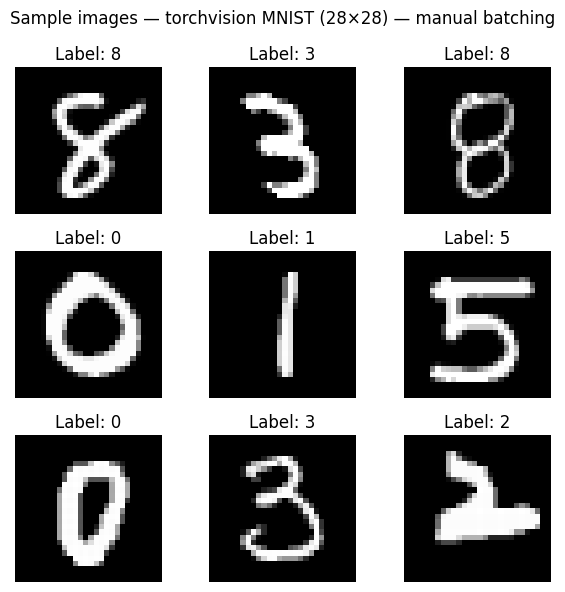

In [122]:
def preview_batch(loader: SimpleLoader, num_images: int = 9) -> None:
    images, labels = next(iter(loader))
    images = images[:num_images]
    labels = labels[:num_images]
    side = int(np.ceil(np.sqrt(num_images)))
    fig, axes = plt.subplots(side, side, figsize=(6, 6))
    for idx, ax in enumerate(axes.flat):
        ax.axis("off")
        if idx >= len(images):
            continue
        img = images[idx].squeeze(0).numpy()
        ax.imshow(img, cmap="gray")
        ax.set_title(f"Label: {int(labels[idx])}")
    fig.suptitle(f"Sample images — {DATASET_NAME}")
    plt.tight_layout()


preview_batch(train_loader)


## 2. Building a Feed-Forward Classifier

We will start by building a simple feed-forward neural network with a single linear layer and a ReLU activation function.

### Input Dimension
- Each image is a $28 \times 28$ pixel greyscale image, which we can flatten into a vector of $28 \times 28 = 784$ features (by flattening the 2D image into a 1D vector).
- For RGB images, each image has 3 channels, so the input dimension is $3 \times 28 \times 28 = 2304$.
- Let $\textbf{x} \in \mathbb{R}^{C \times H \times W}$ be a $C$-channel, $H$-height, $W$-width input image, then the input dimension is $C \times H \times W$.
- Each entry in the input vector $\textbf{x}$ corresponds to intensity of a pixel in the image (i.e., how dark or light the pixel is).
- Values are typically integer in the range $[0, 255]$, and are often normalized to $[0, 1]$ by dividing all values by 255.
- In our case, $C = 1$, $H = 28$, $W = 28$, so the input dimension is $1 \times 28 \times 28 = 784$.

### Output Dimension
- The output dimension is the number of classes, which is 10 for MNIST.
- The output should be a vector $\textbf{y} \in \mathbb{R}^{10}$ for each input image, where each element $y_i$ is the score of class $i$, and $\sum_{i=1}^{10} y_i = 1$.

![Neural Network Diagram](https://ml4a.github.io/images/figures/mnist-input.png)

Source: https://ml4a.github.io/images/figures/mnist-input.png

## Forward pass formula (single layer):

Given input image $\textbf{x}_\text{image} \in \mathbb{R}^{28 \times 28}$:

1. Flatten the input image $\textbf{x}_\text{image} \in \mathbb{R}^{28 \times 28}$ into a vector of dimension $\textbf{x}_\text{flat} \in \mathbb{R}^{784}$

2. Pass through a linear layer with weight matrix $\textbf{W} \in \mathbb{R}^{10 \times 784}$ and bias vector $\textbf{b} \in \mathbb{R}^{10}$ to get the logits $\textbf{z} \in \mathbb{R}^{10}$

3. Apply the softmax function to the logits $\textbf{z}$ to get the class probabilities $\textbf{y} \in \mathbb{R}^{10}$

$$
P(y_i = 1 | \textbf{x}_\text{image}) = \frac{e^{z_i}}{\sum_{j=1}^{10} e^{z_j}}
$$

- Since we only have a single layer, we no acitvation functions have been applied here.
- This is effectively a linear classifier with a 10-dimensional output space (known as the **multinomial regression**).

## Neural networks in PyTorch are built by subclassing nn.Module
nn.Module is the base class for all neural network modules in PyTorch
It provides essential functionality like parameter management, device movement,
and training/evaluation mode switching

Key concepts:
- __init__: Define layers and components
- forward: Define the forward pass computation
- Parameters are automatically registered/tracked when using nn.Linear, nn.Conv2d, etc.

---
Example structure:

```python
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()  # Always call parent constructor
        self.layer1 = ....
        self.layer2 = ....
        self.layer3 = ....

    def forward(self, x):
        x = self.layer1(X)
        x = self.layer2(X)
        x = self.layer3(X)
        return x
```
---

## Class Definition `class MyModel(nn.Module):`
- We create the class by subclassing `nn.Module`.

---
## The intialization method `__init__`
- Define the layers and important components (e.g., activation functions) in the initialization method.
- We need to first call the parent class initalization constructor `super().__init__()`, so that the `nn.Module` can help us for example manage the parameters.

---
## Create linear layers using `nn.Linear`
- `nn.Linear` is a linear layer that takes an input and produces an output.
- The input and output dimensions are specified as arguments.
- By default, there is a bias (intercept) term in the linear layer.
- By default, `nn.Linear` will initialize the weights and biases randomly.
```python
self.layer1 = nn.Linear(input_size, hidden_size)
```
- The above codeblock will create a linear layer with input size `input_size` and output size `hidden_size` used for the following computation:
$$
y = Wx + b, \quad \text{where } W \in \mathbb{R}^{\text{hidden\_size} \times \text{input\_size}}, b \in \mathbb{R}^{\text{hidden\_size}}
$$
- There are $input\_size$ weight parameters and $hidden\_size$ biase (intercept) parameters, which are initialized randomly.

---
## The forward method
The forward method defines how the model transforms the input data to the prediction.

```python
def forward(self, x):
    x = self.layer1(x)
    return x
```

---
The output logits are then passed to `CrossEntropyLoss`, which internally applies the softmax function to compute class probabilities and calculate the loss.

### Note: the CrossEntropyLoss function internally applies the softmax function to compute class probabilities and calculate the loss. So we do not need to apply the softmax function in the forward pass.

In [123]:
class SingleLayer(nn.Module):
    def __init__(self, input_dim: int, output_dim: int):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x_flattened = x.view(x.size(0), -1)
        logits = self.fc1(x_flattened)
        return logits

## Multi-Layer Perceptron (MLP)

We now extend our model to a multi-layer perceptron (MLP) with two linear layers and a ReLU activation function.

Why do we need **activation functions**? 

### The Problem without Activation Functions
Imagine the following **dummy** two linear layers:

$$
h = W_1 x + b_1
$$

and 

$$
h' = W_2 h + b_2
$$

If we did not apply the ReLU activation function to the first layer, then the output of the second layer would be a **linear combination** of the input $x$.

$$
h' = W_2 (W_1 x + b_1) + b_2 = W_2 W_1 x + W_2 b_1 + b_2
$$

This is equivalent to a single linear layer with a different weight matrix and bias vector.

$$
h' = W x + b
$$

In this case, we do not obtain additional expressiveness by adding the second layer.

## Activation Functions

![Activation Functions](https://global.discourse-cdn.com/dlai/original/3X/4/1/4126d155488f62a7adadc8d720d8835a9dad7851.jpeg)


Activation functions introduce non-linearity into the model, allowing the network to learn more complex representations.

$$
\text{ReLU}(x) = \max(0, x)
$$

### ReLU Activation Function
We can apply the non-linear activation function between linear layers to introduce non-linearity.

$$
h = W_1 x + b_1
$$

$$
h'' = W_2 \text{ReLU}(h) + b_2
$$

### Multi-Layer Perceptron (MLP) Forward Pass

Given an input image $x \in \mathbb{R}^{C \times H \times W}$, the forward pass through our MLP consists of the following operations:

1. **Flatten**: Transform the 3D image tensor into a 1D vector
   $$x_{\text{flat}} = \text{flatten}(x) \in \mathbb{R}^{d_{\text{in}}}$$
   where $d_{\text{in}} = C \times H \times W$

2. **First Linear Layer**: Apply affine transformation
   $$h = W_1 x_{\text{flat}} + b_1 \in \mathbb{R}^{d_{\text{hidden}}}$$

3. **ReLU Activation**: Introduce non-linearity
   $$h_{\text{relu}} = \text{ReLU}(h) = \max(0, h)$$

4. **Dropout** (during training only): Randomly zero elements with probability $p = 0.2$ for regularization
   $$h_{\text{drop}} = \text{Dropout}(h_{\text{relu}}, p=0.2)$$

5. **Second Linear Layer**: Map to output logits
   $$\text{logits} = W_2 h_{\text{drop}} + b_2 \in \mathbb{R}^{K}$$
   where $K$ is the number of classes

The output logits are then passed to `CrossEntropyLoss`, which internally applies the softmax function to compute class probabilities and calculate the loss.

### Note: the CrossEntropyLoss function internally applies the softmax function to compute class probabilities and calculate the loss. So we do not need to apply the softmax function in the forward pass.

## Define the Updated Multi-Layer Perceptron (MLP) Class

In [124]:
class MLP(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int=32, output_dim: int=10):
        super().__init__()
        # Flatten the input image tensor into a 1D vector
        self.flatten = nn.Flatten()
        # First linear layer
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        # ReLU activation function
        self.relu = nn.ReLU()
        # Dropout layer
        self.dropout = nn.Dropout(p=0.2)
        # Second linear layer
        self.layer2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Flatten the input image tensor into a 1D vector
        x = self.flatten(x)
        # First linear layer
        x = self.layer1(x)
        # ReLU activation function
        x = self.relu(x)
        # Dropout layer
        x = self.dropout(x)
        # Second linear layer
        x = self.layer2(x)
        return x

## Create the MLP model and visualize the model architecture

In [125]:
model = MLP(784, 128, 10)
model

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer1): Linear(in_features=784, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (layer2): Linear(in_features=128, out_features=10, bias=True)
)

## Use the MLP model for prediction (forward pass)
The `forward()` method defines how the model transforms the input data to the prediction.

Let's start with a random input tensor of shape $(1, 28, 28)$.

The fist dimension is the batch size, which allows us to pass in a batch of images at once.

In [126]:
sample_input = torch.randn(1, 28, 28)
sample_input

tensor([[[-8.8308e-01, -1.8464e-01,  6.9323e-01,  3.2399e-01, -1.4867e+00,
           3.4166e-01, -2.9351e+00,  1.5491e-01, -5.1033e-01, -9.0526e-02,
          -6.7487e-01, -1.0316e+00, -2.5749e-01, -1.8033e+00, -1.0122e-01,
           4.6290e-02,  3.3716e-01,  4.9952e-01,  4.3891e-02,  2.3430e-02,
           2.2270e-01,  1.1331e+00, -7.2289e-01,  8.8854e-01,  1.2247e+00,
           7.5076e-01,  2.5144e-01, -7.6938e-01],
         [-3.4353e-01, -1.7685e-01,  5.9569e-01, -3.2420e-01,  1.7443e+00,
          -9.5570e-01, -1.9314e-01,  1.9466e-01,  2.2343e-01, -7.1943e-01,
          -2.6679e-01,  1.7434e-01,  3.3257e-01,  6.1472e-01,  1.3156e+00,
          -9.2667e-01, -7.8590e-01,  2.0359e-01, -1.0871e+00,  5.8626e-01,
           5.5305e-01,  8.6803e-01,  4.6484e-01, -3.1443e-01,  7.2843e-02,
           4.1236e-01, -5.0028e-01, -4.6238e-01],
         [ 4.5632e-01,  1.9932e+00, -8.8028e-01,  9.5546e-01,  6.0947e-01,
          -2.7057e-01,  3.3626e-01, -1.0004e+00,  7.0061e-01, -1.5045e+00,


In [127]:
## Pass the sample input through the model
logits = model(sample_input)
logits

tensor([[ 0.1658, -0.3497, -0.1529, -0.5305, -0.0918,  0.5281, -0.5381,  0.1181,
          0.0134,  0.4194]], grad_fn=<AddmmBackward0>)

In [128]:
# let's process 10 images together.
sample_batch = torch.randn(128, 28, 28)
print(f"The shape of the sample batch is {sample_batch.shape}")
logits = model(sample_batch)
print(f"The shape of the logits is {logits.shape}")

The shape of the sample batch is torch.Size([128, 28, 28])
The shape of the logits is torch.Size([128, 10])


## View the model architecture
The third party `torchinfo` package can be used to view the model architecture.

In [129]:
# Create a sample input tensor
# Display model summary with input shape
import torchinfo
torchinfo.summary(model, input_size=(256, 28, 28), col_names=["input_size", "output_size", "num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
MLP                                      [256, 28, 28]             [256, 10]                 --
├─Flatten: 1-1                           [256, 28, 28]             [256, 784]                --
├─Linear: 1-2                            [256, 784]                [256, 128]                100,480
├─ReLU: 1-3                              [256, 128]                [256, 128]                --
├─Dropout: 1-4                           [256, 128]                [256, 128]                --
├─Linear: 1-5                            [256, 128]                [256, 10]                 1,290
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 26.05
Input size (MB): 0.80
Forward/backward pass size (MB): 0.28
Params size (MB): 0.41
Estimated Total Size (MB): 1.49

### You can also access the number of `model.parameters()` in the model

In [130]:
print(f"The number of parameters in the model is {sum(p.numel() for p in model.parameters()):,}")

The number of parameters in the model is 101,770


## 3. Training Loop (Forward → Loss → Backward → Update)

- We have define the model class with forward pass.
- To train the model, we need to compute the gradient of the loss with respect to the model parameters.
- Then, we apply the gradient descent algorithm to update the model parameters.

- For ordinary least squares regression, the gradient of the loss with respect to the model parameters has a closed-form solution ($W = (X^T X)^{-1} X^T y$).
- For neural networks, the gradient of the loss with respect to the model parameters is computed using the chain rule.
- But computing the gradient of the loss the chain rule is computationally expensive.
- PyTorch provides a `backward()` method to compute the gradient of the loss with respect to the model parameters automatically (using the automatic differentiation method).
- Then, we apply the gradient descent algorithm to update the model parameters.

In [131]:
model = MLP(784, 256, 10).to(device)

## Create the optimizer to keep track of the model parameters and the corresponding gradients (`torch.optim.Adam`).

In [132]:
# we tell the optimizer `model.parameters()` to keep track of the model parameters and the corresponding gradients.
# we also specify the learning rate `lr=0.03` for the optimizer.
optimizer = torch.optim.Adam(model.parameters(), lr=0.03)

## Create the training loop

In [133]:
def train_one_epoch(
    model: nn.Module,
    loader: DataLoader,
    optimizer: torch.optim.Optimizer,
    verbose: bool=True
) -> tuple[float, float]:
    # set the model to training mode
    model.train()
    # initialize the running loss, correct, and total
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in loader:
        # loop over the batch.
        # inputs: (batch size, 28, 28)
        inputs = inputs.to(device)
        # outputs: (batch size, 10)
        targets = targets.to(device)
        if verbose:
            print(f"The shape of the inputs is {inputs.shape}")
            print(f"The shape of the targets is {targets.shape}")

        # zero the parameter gradients from previous iterations.
        optimizer.zero_grad()
        # forward pass, compute the logits (unnormalized probabilities)
        logits = model(inputs)
        # compute the loss
        loss = nn.functional.cross_entropy(logits, targets)
        # backward pass, compute the gradient of the loss with respect to the model parameters
        loss.backward()
        # update the model parameters
        optimizer.step()

        # update the running loss, correct, and total
        running_loss += loss.item() * inputs.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == targets).sum().item()
        total += targets.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    if verbose:
        print(f"Epoch loss: {epoch_loss:.4f}, Epoch accuracy: {epoch_acc:.3f}")
    return epoch_loss, epoch_acc

## Create the evaluation loop

The `train_one_epoch()` function keeps track of the model parameters and the corresponding gradients. For the evaluation loop, we do not need to compute the gradient of the loss (because we are not updating the model parameters using the validation set). 

We use the `torch.no_grad()` decorator to disable gradient computation to speed up the evaluation process.

In [134]:
@torch.no_grad()
def evaluate(model: nn.Module, loader: DataLoader) -> tuple[float, float]:
    # set the model to evaluation mode (disables dropout, batch norm, etc.)
    model.eval()
    # initialize the running loss, correct, and total
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in loader:
        # move inputs and targets to the device
        inputs = inputs.to(device)
        targets = targets.to(device)
        # forward pass, compute the logits (unnormalized probabilities)
        logits = model(inputs)
        # compute the loss
        loss = nn.functional.cross_entropy(logits, targets)
        # update the running loss
        running_loss += loss.item() * inputs.size(0)
        # get the predicted class (index of the maximum logit)
        preds = logits.argmax(dim=1)
        # update the number of correct predictions
        correct += (preds == targets).sum().item()
        # update the total number of samples
        total += targets.size(0)

    # return the average loss and accuracy
    return running_loss / total, correct / total

In [135]:
# there are 60000 / 256 = 234.375 batches in the training set.
len(train_loader)

12

In [136]:
# Demo the train_one_epoch function on a single epoch
train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, verbose=True)
print(f"\nTraining complete: loss={train_loss:.4f}, accuracy={train_acc:.3f}")

# Evaluate on the test set
test_loss, test_acc = evaluate(model, test_loader)
print(f"Test evaluation: loss={test_loss:.4f}, accuracy={test_acc:.3f}")

The shape of the inputs is torch.Size([5120, 28, 28])
The shape of the targets is torch.Size([5120])
The shape of the inputs is torch.Size([5120, 28, 28])
The shape of the targets is torch.Size([5120])
The shape of the inputs is torch.Size([5120, 28, 28])
The shape of the targets is torch.Size([5120])
The shape of the inputs is torch.Size([5120, 28, 28])
The shape of the targets is torch.Size([5120])
The shape of the inputs is torch.Size([5120, 28, 28])
The shape of the targets is torch.Size([5120])
The shape of the inputs is torch.Size([5120, 28, 28])
The shape of the targets is torch.Size([5120])
The shape of the inputs is torch.Size([5120, 28, 28])
The shape of the targets is torch.Size([5120])
The shape of the inputs is torch.Size([5120, 28, 28])
The shape of the targets is torch.Size([5120])
The shape of the inputs is torch.Size([5120, 28, 28])
The shape of the targets is torch.Size([5120])
The shape of the inputs is torch.Size([5120, 28, 28])
The shape of the targets is torch.Siz

In [137]:
EPOCHS = 50
history = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, verbose=False)
    test_loss, test_acc = evaluate(model, test_loader)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["test_loss"].append(test_loss)
    history["test_acc"].append(test_acc)

    print(
        f"Epoch {epoch:02d}/{EPOCHS} — "
        f"train_loss: {train_loss:.4f}, train_acc: {train_acc:.3f} | "
        f"test_loss: {test_loss:.4f}, test_acc: {test_acc:.3f}"
    )

Epoch 01/50 — train_loss: 0.3516, train_acc: 0.895 | test_loss: 0.2212, test_acc: 0.932
Epoch 02/50 — train_loss: 0.2364, train_acc: 0.930 | test_loss: 0.1658, test_acc: 0.950
Epoch 03/50 — train_loss: 0.1848, train_acc: 0.945 | test_loss: 0.1388, test_acc: 0.957
Epoch 04/50 — train_loss: 0.1501, train_acc: 0.954 | test_loss: 0.1227, test_acc: 0.964
Epoch 05/50 — train_loss: 0.1297, train_acc: 0.960 | test_loss: 0.1102, test_acc: 0.966
Epoch 06/50 — train_loss: 0.1169, train_acc: 0.964 | test_loss: 0.1025, test_acc: 0.969
Epoch 07/50 — train_loss: 0.1014, train_acc: 0.968 | test_loss: 0.0982, test_acc: 0.971
Epoch 08/50 — train_loss: 0.0917, train_acc: 0.972 | test_loss: 0.0942, test_acc: 0.971
Epoch 09/50 — train_loss: 0.0835, train_acc: 0.974 | test_loss: 0.0913, test_acc: 0.972
Epoch 10/50 — train_loss: 0.0776, train_acc: 0.976 | test_loss: 0.0924, test_acc: 0.973
Epoch 11/50 — train_loss: 0.0728, train_acc: 0.977 | test_loss: 0.0902, test_acc: 0.973
Epoch 12/50 — train_loss: 0.0678

## 4. Evaluation & Diagnostics

We will compute accuracy, inspect the confusion matrix, and visualize a handful of mistakes to diagnose model behavior.

The confusion matrix shows how often each true class is predicted as each possible class. Diagonal entries represent correct predictions, while off-diagonal entries indicate misclassifications. Darker blue cells indicate higher counts.


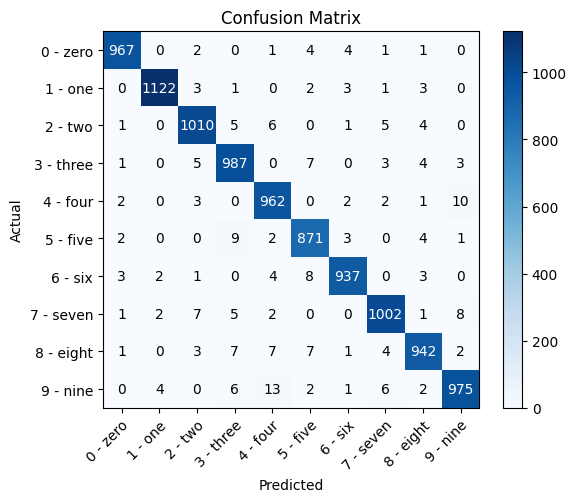

Overall test accuracy: 0.978


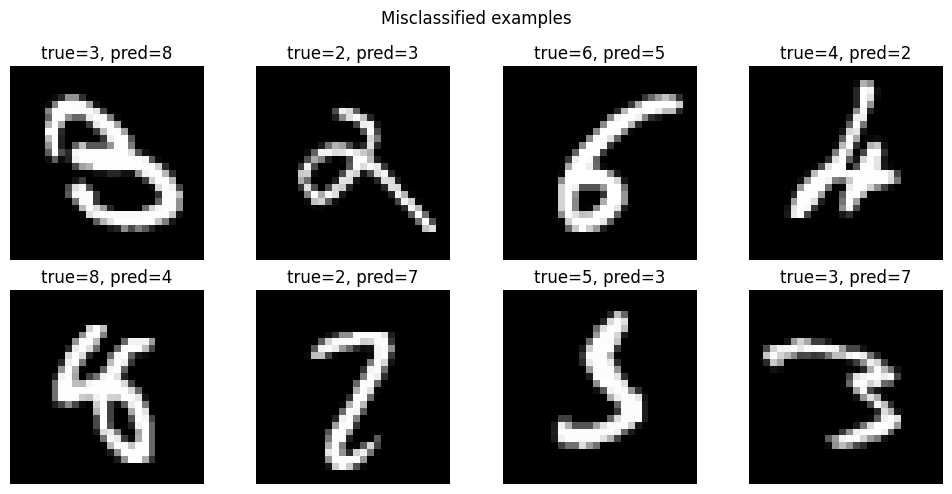

In [138]:
@torch.no_grad()
def collect_predictions(model: nn.Module, loader: DataLoader) -> tuple[np.ndarray, np.ndarray, torch.Tensor]:
    model.eval()
    all_preds: list[torch.Tensor] = []
    all_targets: list[torch.Tensor] = []
    all_images: list[torch.Tensor] = []

    for inputs, targets in loader:
        inputs = inputs.to(device)
        logits = model(inputs)
        preds = logits.argmax(dim=1)
        all_preds.append(preds.cpu())
        all_targets.append(targets.clone())
        all_images.append(inputs.cpu())

    preds_tensor = torch.cat(all_preds)
    targets_tensor = torch.cat(all_targets)
    images_tensor = torch.cat(all_images)
    return preds_tensor.numpy(), targets_tensor.numpy(), images_tensor


preds, targets, images = collect_predictions(model, test_loader)
cm = confusion_matrix(targets, preds)

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set_xticks(range(len(LABEL_NAMES)))
ax.set_yticks(range(len(LABEL_NAMES)))
ax.set_xticklabels(LABEL_NAMES)
ax.set_yticklabels(LABEL_NAMES)
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
ax.set_title("Confusion Matrix")
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Annotate cells with counts
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center", color="white" if cm[i, j] > cm.max() / 2 else "black")

plt.tight_layout()
plt.show()

accuracy = (preds == targets).mean()
print(f"Overall test accuracy: {accuracy:.3f}")

mis_idx = np.where(preds != targets)[0]
if len(mis_idx) == 0:
    print("Model is perfect on the test set — no misclassifications to display!")
else:
    num_examples = min(8, len(mis_idx))
    fig, axes = plt.subplots(2, 4, figsize=(10, 5))
    for ax, idx in zip(axes.flat, mis_idx[:num_examples]):
        ax.axis("off")
        ax.imshow(images[idx].squeeze(0), cmap="gray")
        ax.set_title(f"true={targets[idx]}, pred={preds[idx]}")
    fig.suptitle("Misclassified examples")
    plt.tight_layout()
    plt.show()


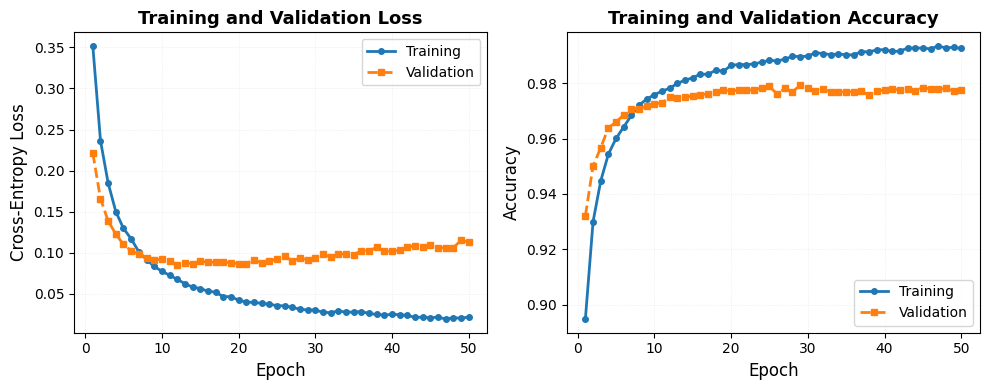

In [141]:
epochs = range(1, EPOCHS + 1)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Loss subplot
axes[0].plot(epochs, history["train_loss"], marker="o", linestyle="-", linewidth=2, markersize=4, label="Training")
axes[0].plot(epochs, history["test_loss"], marker="s", linestyle="--", linewidth=2, markersize=4, label="Validation")
axes[0].set_xlabel("Epoch", fontsize=12)
axes[0].set_ylabel("Cross-Entropy Loss", fontsize=12)
axes[0].set_title("Training and Validation Loss", fontsize=13, fontweight="bold")
axes[0].legend(loc="best", frameon=True, fontsize=10)
axes[0].grid(True, alpha=0.3, linestyle=":", linewidth=0.5)

# Accuracy subplot
axes[1].plot(epochs, history["train_acc"], marker="o", linestyle="-", linewidth=2, markersize=4, label="Training")
axes[1].plot(epochs, history["test_acc"], marker="s", linestyle="--", linewidth=2, markersize=4, label="Validation")
axes[1].set_xlabel("Epoch", fontsize=12)
axes[1].set_ylabel("Accuracy", fontsize=12)
axes[1].set_title("Training and Validation Accuracy", fontsize=13, fontweight="bold")
axes[1].legend(loc="best", frameon=True, fontsize=10)
axes[1].grid(True, alpha=0.3, linestyle=":", linewidth=0.5)

plt.tight_layout()
plt.show()


## 5. Saving and Loading Models

PyTorch recommends saving and loading model `state_dict`s. We will persist the trained weights to `./mnist_mlp.pt`, reinstantiate a fresh model, and verify that performance matches.


In [143]:
MODEL_PATH = "./temp_mnist_mlp.pt"

torch.save(model.state_dict(), MODEL_PATH)
print(f"Saved model parameters to {MODEL_PATH}")

Saved model parameters to ./temp_mnist_mlp.pt


In [148]:
reloaded_model = MLP(input_dim=28*28, hidden_dim=256, output_dim=10).to(device)
reloaded_model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
reloaded_model.eval()

_, reloaded_acc = evaluate(reloaded_model, test_loader)
print(f"Reloaded model test accuracy: {reloaded_acc:.3f}")

Reloaded model test accuracy: 0.978
